# Projeção da população brasileira por sexo e grupos de idade, 2010-2070

In [7]:
import shutil
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

## 1. Baixar e carregar os dados de projeção da população brasileira do IBGE versão 2024 (2000-2070)

Fonte: https://www.ibge.gov.br/estatisticas/sociais/populacao/9109-projecao-da-populacao.html

In [8]:
url = "https://ftp.ibge.gov.br/Projecao_da_Populacao/Projecao_da_Populacao_2024/projecoes_2024_tab2_grupo_quinquenal.xlsx"
dest_dir = Path("data")
if not dest_dir.exists():
    dest_dir.mkdir()
dest_file = dest_dir / "projecoes_2024_tab2_grupo_quinquenal.xlsx"
if not dest_file.exists():
    with open(dest_file, "wb") as f:
        f.write(requests.get(url).content)

df = pd.read_excel(
    dest_file, sheet_name="2) POP_GRUPO QUINQUENAL", skiprows=5,
)
df

,GRUPO ETÁRIO,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,...,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070
0,00-04,Ambos,0,BR,Brasil,17281547,17123682,16906493,16640256,16343284,...,8279456,8177111,8079433,7987391,7901241,7820627,7744772,7673320,7606268,7543093
1,05-09,Ambos,0,BR,Brasil,17378990,17390172,17379924,17349975,17303761,...,8820606,8708567,8596707,8485608,8376598,8270750,8168636,8071186,7979360,7893433
2,10-14,Ambos,0,BR,Brasil,17599378,17471598,17382310,17339680,17333773,...,9347726,9246401,9142645,9036015,8926567,8815236,8703349,8591634,8480688,8371817
3,15-19,Ambos,0,BR,Brasil,17831344,17866394,17852790,17786266,17669276,...,9808849,9718189,9626310,9532355,9435826,9336980,9236029,9132638,9026379,8917283
4,20-24,Ambos,0,BR,Brasil,16402228,16826765,17170628,17423254,17594842,...,10227566,10139675,10052257,9964592,9876311,9787218,9697332,9606213,9512994,9417186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,70-74,Mulheres,53,DF,Distrito Federal,11840,12438,13036,13664,14353,...,104958,103218,102145,101666,101619,101741,101836,101892,101969,101931
1877,75-79,Mulheres,53,DF,Distrito Federal,7538,8134,8730,9313,9881,...,107630,106136,104243,101998,99664,97590,96010,95051,94638,94620
1878,80-84,Mulheres,53,DF,Distrito Federal,4642,4834,5094,5403,5745,...,92222,94076,95059,95261,94798,93847,92559,90920,88976,86956
1879,85-89,Mulheres,53,DF,Distrito Federal,2459,2568,2686,2823,2974,...,58743,61035,63533,66151,68640,70702,72133,72898,73079,72771


## 2. Tratar os dados para facilitar a análise

In [24]:
dados = (
    df.melt(
        id_vars=["GRUPO ETÁRIO", "SEXO", "CÓD.", "SIGLA", "LOCAL"],
        var_name="ANO",
        value_name="POPULAÇÃO",
    )
    .drop(columns=["CÓD."])
    .assign(**{"GRUPO ETÁRIO": lambda x: x["GRUPO ETÁRIO"].str.strip(), "ANO": lambda x: pd.to_datetime(x["ANO"], format="%Y")})
    .query("SEXO != 'Ambos'")
)
dados

,GRUPO ETÁRIO,SEXO,SIGLA,LOCAL,ANO,POPULAÇÃO
19,00-04,Homens,BR,Brasil,2000-01-01,8739233
20,05-09,Homens,BR,Brasil,2000-01-01,8710340
21,10-14,Homens,BR,Brasil,2000-01-01,8800488
22,15-19,Homens,BR,Brasil,2000-01-01,8880452
23,20-24,Homens,BR,Brasil,2000-01-01,8118846
...,...,...,...,...,...,...
133546,70-74,Mulheres,DF,Distrito Federal,2070-01-01,101931
133547,75-79,Mulheres,DF,Distrito Federal,2070-01-01,94620
133548,80-84,Mulheres,DF,Distrito Federal,2070-01-01,86956
133549,85-89,Mulheres,DF,Distrito Federal,2070-01-01,72771


Atribuir números às faixas etárias.

In [25]:
_faixa = [
    '00-04',
    '05-09',
    '10-14',
    '15-19',
    '20-24',
    '25-29',
    '30-34',
    '35-39',
    '40-44',
    '45-49',
    '50-54',
    '55-59',
    '60-64',
    '65-69',
    '70-74',
    '75-79',
    '80-84',
    '85-89',
    '90+',
]
_idade = [(2* i + 5) / 2 for i in range(0, 90, 5)] + [92.5]
idade = pd.DataFrame({"GRUPO ETÁRIO": _faixa, "idade": _idade})
idade

,GRUPO ETÁRIO,idade
0,00-04,2.5
1,05-09,7.5
2,10-14,12.5
3,15-19,17.5
4,20-24,22.5
5,25-29,27.5
6,30-34,32.5
7,35-39,37.5
8,40-44,42.5
9,45-49,47.5


In [26]:
dados2 = dados.merge(idade, how="left")
dados2

,GRUPO ETÁRIO,SEXO,SIGLA,LOCAL,ANO,POPULAÇÃO,idade
0,00-04,Homens,BR,Brasil,2000-01-01,8739233,2.5
1,05-09,Homens,BR,Brasil,2000-01-01,8710340,7.5
2,10-14,Homens,BR,Brasil,2000-01-01,8800488,12.5
3,15-19,Homens,BR,Brasil,2000-01-01,8880452,17.5
4,20-24,Homens,BR,Brasil,2000-01-01,8118846,22.5
...,...,...,...,...,...,...,...
89029,70-74,Mulheres,DF,Distrito Federal,2070-01-01,101931,72.5
89030,75-79,Mulheres,DF,Distrito Federal,2070-01-01,94620,77.5
89031,80-84,Mulheres,DF,Distrito Federal,2070-01-01,86956,82.5
89032,85-89,Mulheres,DF,Distrito Federal,2070-01-01,72771,87.5


Funções para formatar os eixos x e y.

In [27]:
def formatter_x(x, p):
    if x == 0:
        return "0"
    else:
        return f"{abs(x)/10**6:.0f} mi"


def formatter_y(x, p):
    if x < 90:
        return f"{x-2.5: >2.0f}-{x+1.5: <2.0f}"
    else:
        return "90+"

Configuração do estilo dos gráficos.

In [13]:
sns.set_style("whitegrid")
font = {"family": "serif", "weight": "normal", "size": 20}
matplotlib.rc("font", **font)

Função para plotar o gráfico de pirâmide etária de um dado ano.

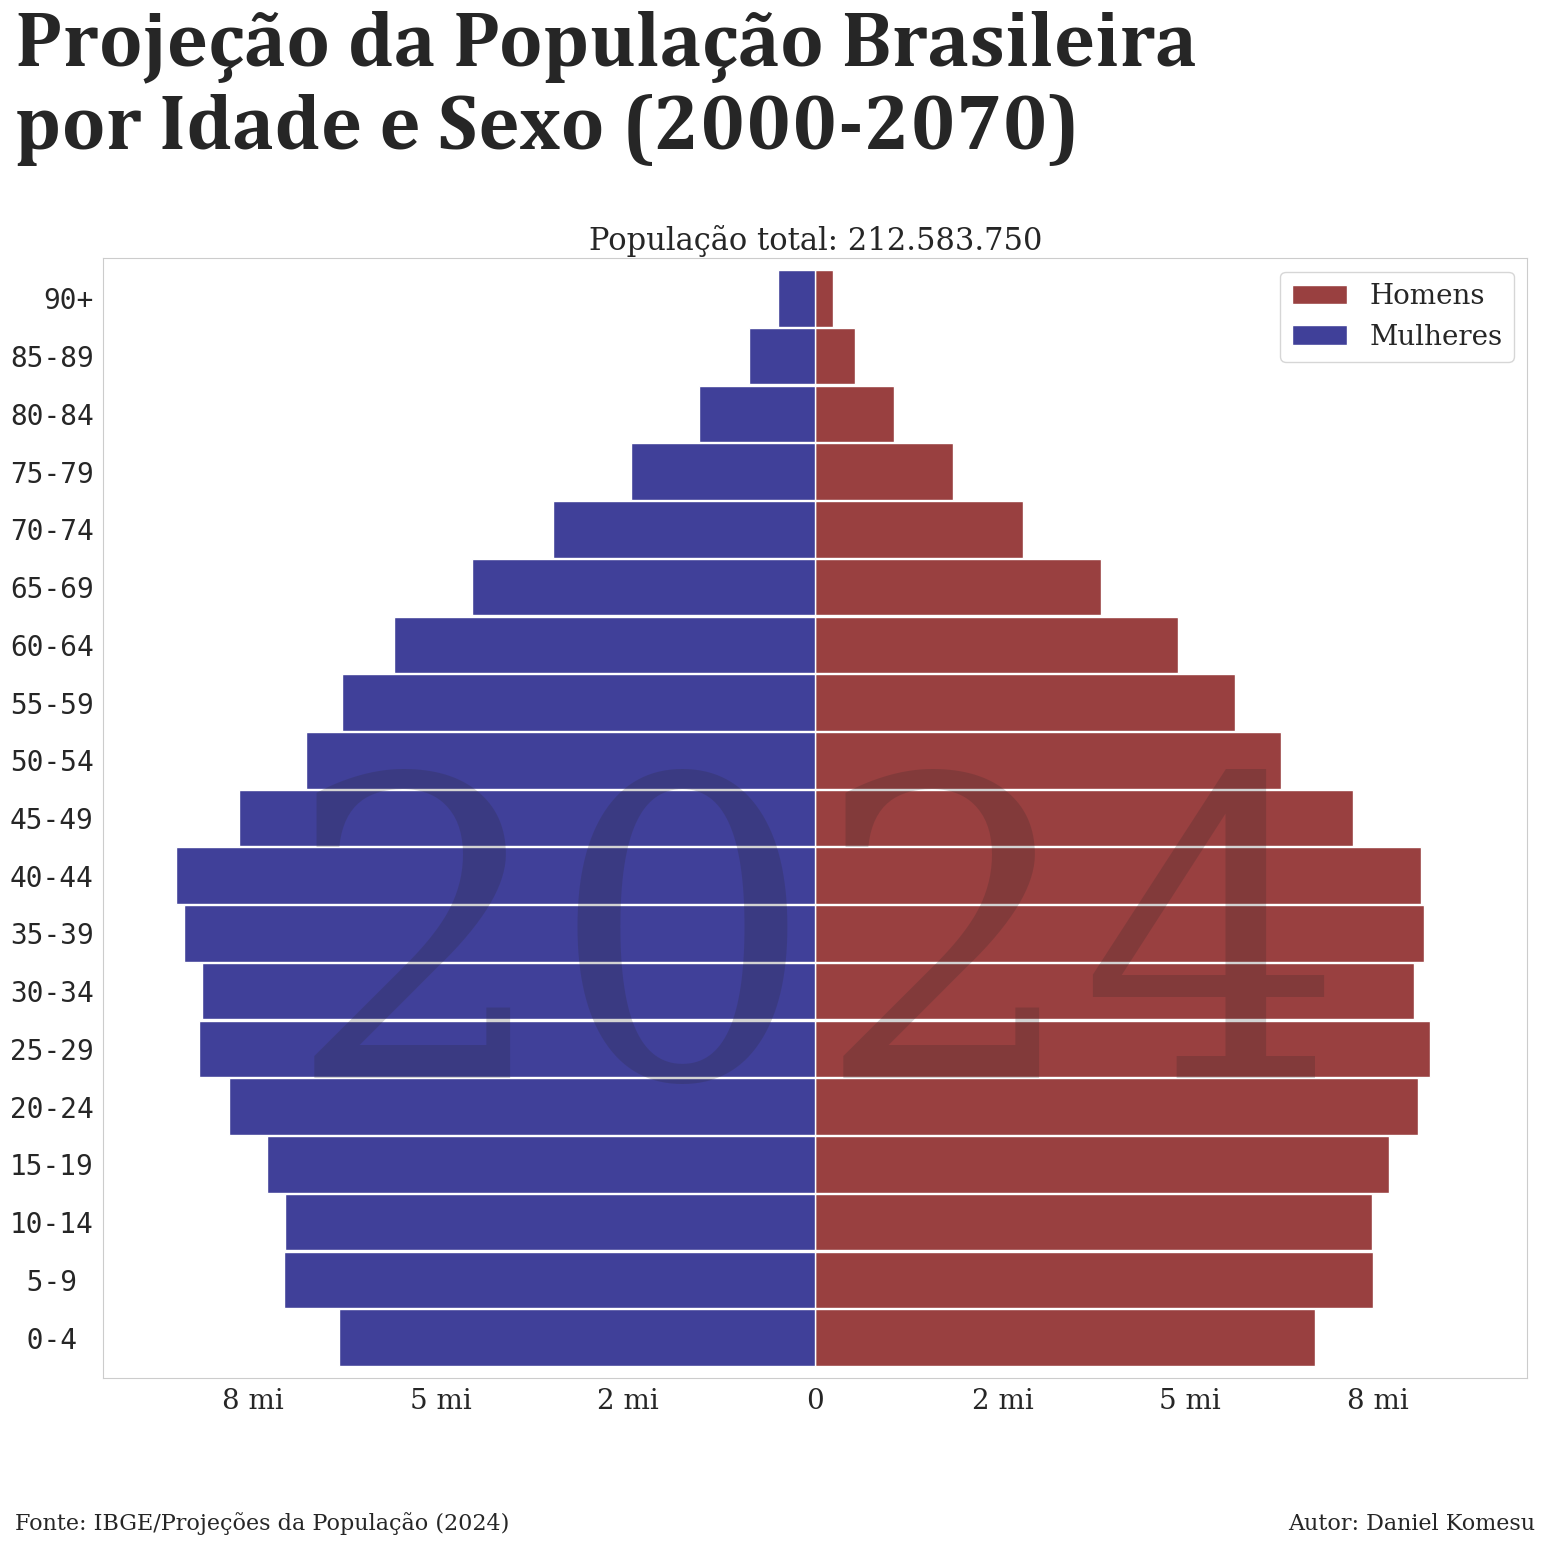

In [29]:
def plot_pop_pyramid(data, date):
    dh = data.loc[(data["SEXO"] == "Homens") & (data["ANO"] == date)]
    dm = data.loc[(data["SEXO"] == "Mulheres") & (data["ANO"] == date)]
    f, ax = plt.subplots()
    f.set_size_inches(16, 16)
    h = ax.barh(
        dh["idade"],
        dh["POPULAÇÃO"],
        height=4.9,
        color=(0.6, 0.25, 0.25),
        label="Homens",
    )
    m = ax.barh(
        dm["idade"],
        dm["POPULAÇÃO"] * -1,
        height=4.9,
        color=(0.25, 0.25, 0.6),
        label="Mulheres",
    )
    f.suptitle(
        "Projeção da População Brasileira\npor Idade e Sexo (2000-2070)",
        fontfamily="Cambria",
        fontsize=56,
        fontweight="bold",
        horizontalalignment="left",
        x=0.025,
        y=0.975,
    )
    total_pop = data.loc[data["ANO"] == date, "POPULAÇÃO"].sum()
    ax.set_title(f"População total: {int(total_pop):,}".replace(",", "."), fontsize=22)
    ax.xaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(formatter_x)
    )
    ax.set_yticks(np.arange(2.5, 95, 5))
    ax.yaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(formatter_y))
    for t in ax.get_yticklabels():
        t.set_fontname("monospace")
    ax.set_xlim(-9.5*10**6, 9.5*10**6)
    ax.set_ylim(bottom=-1, top=96)
    ax.legend(handles=[h, m], loc="upper right")
    ax.grid(False)
    ax.text(0, 25, date.year, size=300, alpha=0.2, horizontalalignment="center")
    ax.set_position([0.08, 0.12, 0.89, 0.7])  # [left, bottom, width, height]
    plt.figtext(x=0.025, y=0.025, s="Fonte: IBGE/Projeções da População (2024)", fontsize=16)
    plt.figtext(x=0.975, y=0.025, s="Autor: Daniel Komesu", fontsize=16, horizontalalignment="right")
    return f, ax


data = dados2[dados2["LOCAL"] == "Brasil"]
date = pd.to_datetime("2024", format="%Y")
f, ax = plot_pop_pyramid(data, date)
plt.savefig("teste.png")

## Interpolação para maior frequência de dados

Os dados das projeções da população brasileira são anuais. Para uma visualização mais fluida, vamos interpolar os dados para obter uma frequência maior.

In [30]:
data_br = dados2[dados2["LOCAL"] == "Brasil"].drop(columns=["LOCAL", "SIGLA"]).query("SEXO != 'Ambos'")
data_br

,GRUPO ETÁRIO,SEXO,ANO,POPULAÇÃO,idade
0,00-04,Homens,2000-01-01,8739233,2.5
1,05-09,Homens,2000-01-01,8710340,7.5
2,10-14,Homens,2000-01-01,8800488,12.5
3,15-19,Homens,2000-01-01,8880452,17.5
4,20-24,Homens,2000-01-01,8118846,22.5
...,...,...,...,...,...
87813,70-74,Mulheres,2070-01-01,7138799,72.5
87814,75-79,Mulheres,2070-01-01,6552619,77.5
87815,80-84,Mulheres,2070-01-01,5647128,82.5
87816,85-89,Mulheres,2070-01-01,4316511,87.5


In [31]:
data_br_homens = data_br.query("SEXO == 'Homens'").pivot_table(
    index=["ANO"],
    columns="GRUPO ETÁRIO",
    values="POPULAÇÃO",
    aggfunc="sum",
)
data_br_mulheres = data_br.query("SEXO == 'Mulheres'").pivot_table(
    index=["ANO"],
    columns="GRUPO ETÁRIO",
    values="POPULAÇÃO",
    aggfunc="sum",
)
years = pd.date_range(start="2000-01-01", end="2070-01-01", freq="D")
data_br_homens = data_br_homens.reindex(years).interpolate(method="time").resample(
    "ME"
).mean().stack().reset_index().rename(columns={"level_0": "ANO", 0: "POPULAÇÃO"}).assign(SEXO="Homens")
data_br_mulheres = data_br_mulheres.reindex(years).interpolate(method="time").resample(
    "ME"
).mean().stack().reset_index().rename(columns={"level_0": "ANO", 0: "POPULAÇÃO"}).assign(SEXO="Mulheres")
data_br_interpol = pd.concat([data_br_homens, data_br_mulheres]).merge(idade, how="left")
data_br_interpol

,ANO,GRUPO ETÁRIO,POPULAÇÃO,SEXO,idade
0,2000-01-31,00-04,8.736737e+06,Homens,2.5
1,2000-01-31,05-09,8.710914e+06,Homens,7.5
2,2000-01-31,10-14,8.797976e+06,Homens,12.5
3,2000-01-31,15-19,8.881408e+06,Homens,17.5
4,2000-01-31,20-24,8.127378e+06,Homens,22.5
...,...,...,...,...,...
31953,2070-01-31,70-74,7.138799e+06,Mulheres,72.5
31954,2070-01-31,75-79,6.552619e+06,Mulheres,77.5
31955,2070-01-31,80-84,5.647128e+06,Mulheres,82.5
31956,2070-01-31,85-89,4.316511e+06,Mulheres,87.5


In [33]:
dest_plots_dir = Path("plots")
dest_plots_dir.mkdir(parents=True, exist_ok=True)
data = data_br_interpol

x = 0
for date in pd.date_range(start="2000-01", end="2070-02", freq="ME"):
    dest_plot_filepath = dest_plots_dir / f"{x:05}.png"
    # if dest_plot_filepath.exists():
    #     x += 1
    #     continue
    f, ax = plot_pop_pyramid(data, date)
    plt.savefig(dest_plot_filepath, dpi=300)
    plt.close()
    print(f"Saved {dest_plot_filepath}\r", end="")
    x += 1
for i in range(120):
    shutil.copy(dest_plot_filepath, dest_plots_dir / f"{x+i:05}.png")

In [34]:
!ffmpeg -v warning -i plots/%05d.png -vf "fps=24,scale=1000:-1:flags=lanczos,palettegen" -y palette.png
!ffmpeg -v warning -i plots/%05d.png -i palette.png -lavfi "fps=24,scale=1000:-1:flags=lanczos [x]; [x][1:v] paletteuse" -y out.gif

[image2 @ 000001c4e9234d00] The specified filename 'palette.png' does not contain an image sequence pattern or a pattern is invalid.
[image2 @ 000001c4e9234d00] Use a pattern such as %03d for an image sequence or use the -update option (with -frames:v 1 if needed) to write a single image.


<img src="out.gif" alt="Projeção da População Brasileira por Idade e Sexo (2000-2070)" width="1000" height="1000">
